In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dropout, BatchNormalization, Reshape, Multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [10]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Define SEBlock
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(input_shape[-1] // self.reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(input_shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, input_shape[-1]))
        self.multiply = Multiply()

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape(se)
        return self.multiply([inputs, se])

    def get_config(self):
        config = super(SEBlock, self).get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config

In [11]:
# train_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Training'
# test_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Testing'
train_path = 'brain_tumor_dataset/Training_balanced'
test_path = 'brain_tumor_dataset/Testing_balanced'

In [12]:
train_df = train_df(train_path)
test_df = test_df(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])
valid_df

,Class Path,Class
1116,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
917,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
195,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
455,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
861,brain_tumor_dataset/Testing_balanced/glioma/Te...,glioma
...,...,...
121,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
118,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
415,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
341,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 256
img_size = (224, 224)

_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5284 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


In [14]:
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {test_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")

Training samples: 5284
Validation samples: 600
Validation samples: 600


In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

EPOCHS = 10
checkpoint_filepath = './ckpt/checkpoint_xception.model.keras'
model_temp = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_temp.trainable = False

model = Sequential()
model.add(model_temp)
model.add(AveragePooling2D(pool_size=(2, 2)))
# model.add(SEBlock())
model.add(Flatten())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())

# Add additional layers
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.summary()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-01-09 19:24:57.051888: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-09 19:24:57.051908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-09 19:24:57.051914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-09 19:24:57.051929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-09 19:24:57.051941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 3, 3, 2048)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,649,196 (97.84 MB)

 Trainable params: 4,786,692 (18.26 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

Num GPUs Available:  1


In [16]:
import time
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[lr_scheduler, model_checkpoint_callback]
)

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=10,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // test_generator.batch_size
# )

# model.save('MobileNetV350epochs64batch_size')
end_time = time.time()

print('The training of the Transfer Learning model took',round((end_time-start_time)/60),'minutes.')

/Users/gary/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-01-09 19:25:08.005289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6056 - loss: 1.2498 - val_accuracy: 0.7100 - val_loss: 4.6117 - learning_rate: 0.0100
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8348 - loss: 0.4518 - val_accuracy: 0.7867 - val_loss: 1.5488 - learning_rate: 0.0100
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8509 - loss: 0.4061 - val_accuracy: 0.8033 - val_loss: 0.9420 - learning_rate: 0.0100
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8643 - loss: 0.3661 - val_accuracy: 0.8050 - val_loss: 0.7897 - learning_rate: 0.0100
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8746 - loss: 0.3427 - val_accuracy: 0.8483 - val_loss: 0.6127 - learning_rate: 0.0100
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8953 - loss: 0.2859 - val_accuracy: 0.8733 - val_loss: 0.4266 - learning_rate: 0.0100
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8873 - loss: 0.3237 - val_accuracy: 0.8250 - va

In [28]:
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
best_model = tf.keras.models.load_model('ckpt/checkpoint_xception.model.keras')
test_loss, test_accuracy = best_model.evaluate(
    test_gen,
    # steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9493 - loss: 0.1510
Test Loss: 0.158
Test Accuracy: 94.67%


In [29]:
print(history.history)

{'accuracy': [0.7163134217262268, 0.8323239684104919, 0.8559803366661072, 0.8586298227310181, 0.8771764039993286, 0.8900454044342041, 0.8972369432449341, 0.897426187992096, 0.9057531952857971, 0.9051854610443115, 0.9101060032844543, 0.9116199612617493, 0.9214609861373901, 0.9242997765541077, 0.9265707731246948, 0.9246782660484314, 0.9290310144424438, 0.929977297782898, 0.9379258155822754, 0.9356548190116882, 0.9430356025695801, 0.9366010427474976, 0.9401968121528625, 0.942089319229126, 0.9430356025695801, 0.9441710710525513, 0.9419000744819641, 0.9443603157997131, 0.9468206167221069, 0.9462528228759766, 0.9417108297348022, 0.9466313123703003, 0.9417108297348022, 0.9462528228759766, 0.9504163265228271, 0.949280858039856, 0.9483345746994019, 0.9507948756217957, 0.9487131237983704, 0.9530658721923828, 0.9479560852050781, 0.9506056308746338, 0.9506056308746338, 0.9485238194465637, 0.9519303441047668, 0.9526873826980591, 0.9494701027870178, 0.954201340675354, 0.9507948756217957, 0.950984120

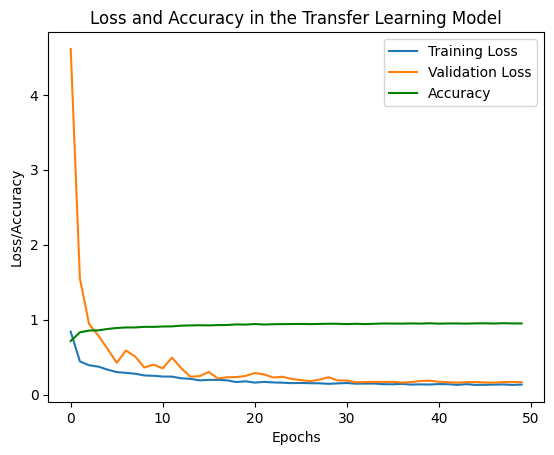

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history["accuracy"],label='Accuracy' ,c="green")
plt.title("Loss and Accuracy in the Transfer Learning Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(best_model.predict(test_gen),axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step


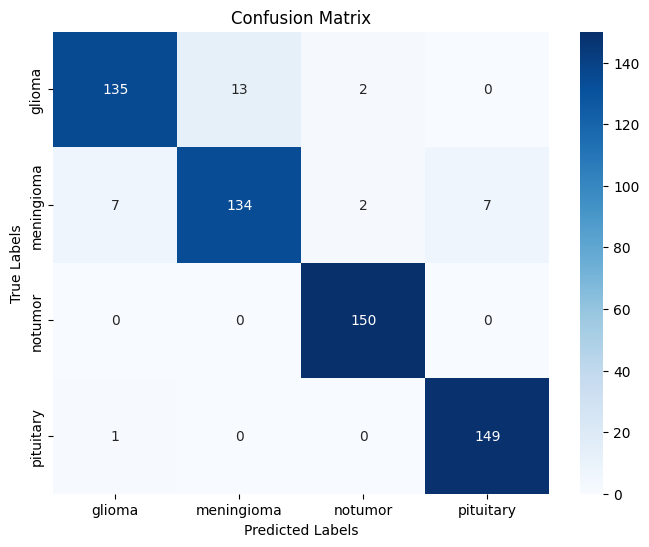

In [27]:
import seaborn as sns

true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
